In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import json
import pytesseract
import math
import statistics

plt.rcParams['figure.figsize'] = [20, 15]

### First load the image for analysis...

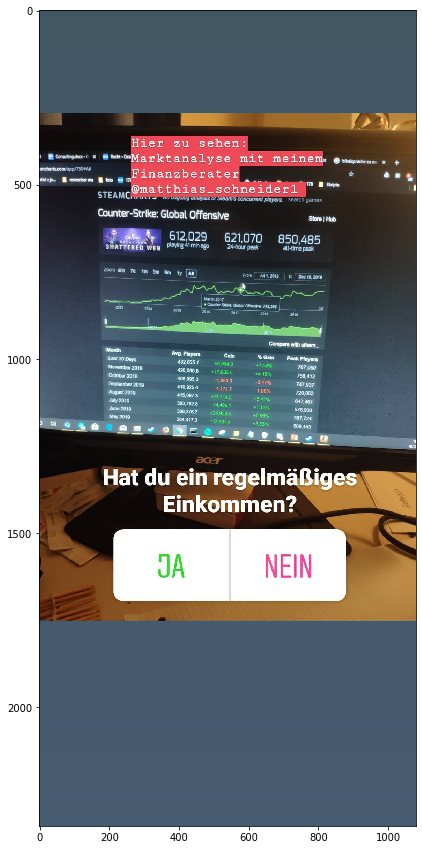

In [2]:
img = cv2.imread("../test/data/story.jpg")

def display_image_plot(_img):
    if len(_img.shape) == 3 and _img.shape[2] == 3 :
        plt.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(_img, cmap='gray')
        
def display_image(_img):
    cv2.imshow("", _img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
display_image_plot(img)

### Analysis

Try to find the rectangle containing the choices for the story.

The box is always pure #FFFFFF, so filter for color first, to find the location of the box.

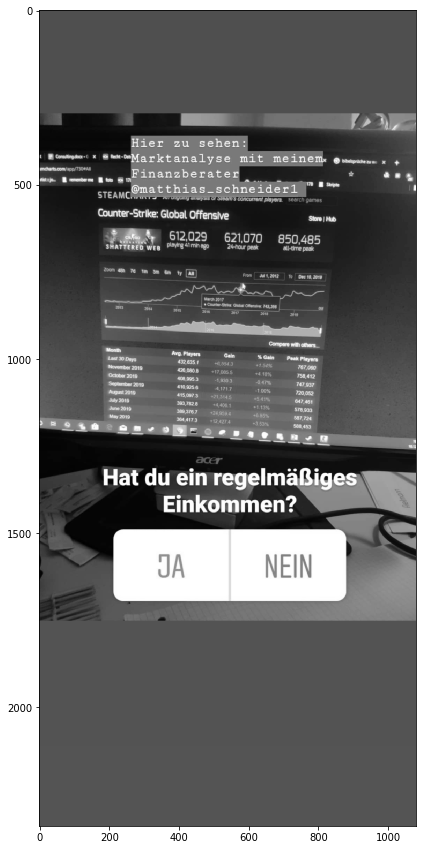

In [3]:
img_gs = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
img_gs = cv2.GaussianBlur(img_gs.copy(), (5,5), 0)

mask = cv2.inRange(img_gs.copy(), np.array([250]), np.array([255]))

display_image_plot(img_gs)

Now find the contour of the big box and discard elements smaller than the biggest two elements.

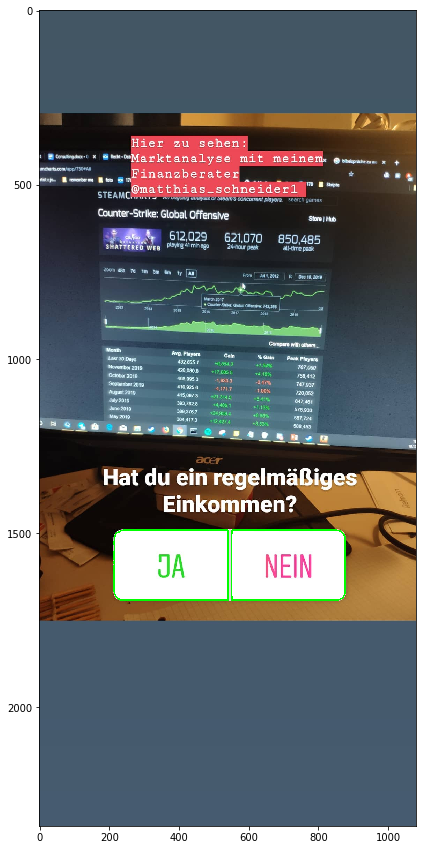

In [4]:
img_area = img.shape[0] * img.shape[1]

CONTOUR_MIN=0.02 * img_area
CONTOUR_MAX=0.03 * img_area

contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_filtered = list(filter(lambda _x: CONTOUR_MIN < cv2.contourArea(_x) < CONTOUR_MAX, contours))

display_image_plot(cv2.drawContours(img.copy(), contours_filtered, -1, (0, 255, 0), 3))

Finally, we need to isolate the yes/no dialog => Find matching shapes. First save the found contours to json.

In [5]:
yes_contour = contours_filtered[1]
no_contour = contours_filtered[0]

json_string = json.dumps({
    "yes": yes_contour.tolist(),
    "no": no_contour.tolist()
})

json_string

'{"yes": [[[240, 1491]], [[239, 1492]], [[235, 1492]], [[234, 1493]], [[232, 1493]], [[232, 1494]], [[230, 1496]], [[229, 1495]], [[228, 1495]], [[227, 1496]], [[226, 1496]], [[220, 1502]], [[220, 1503]], [[219, 1504]], [[219, 1505]], [[218, 1506]], [[218, 1507]], [[217, 1508]], [[217, 1510]], [[216, 1511]], [[216, 1521]], [[215, 1522]], [[215, 1533]], [[216, 1534]], [[216, 1551]], [[215, 1552]], [[215, 1567]], [[216, 1568]], [[215, 1569]], [[215, 1575]], [[216, 1576]], [[216, 1580]], [[215, 1581]], [[215, 1588]], [[216, 1589]], [[216, 1590]], [[215, 1591]], [[215, 1667]], [[216, 1668]], [[216, 1673]], [[217, 1674]], [[217, 1676]], [[219, 1678]], [[219, 1679]], [[220, 1680]], [[220, 1681]], [[224, 1685]], [[224, 1686]], [[225, 1687]], [[226, 1687]], [[227, 1688]], [[228, 1688]], [[229, 1689]], [[230, 1689]], [[231, 1690]], [[232, 1690]], [[233, 1691]], [[236, 1691]], [[237, 1692]], [[541, 1692]], [[541, 1491]]], "no": [[[552, 1491]], [[552, 1503]], [[551, 1504]], [[551, 1679]], [[552, 

Now filter the contours by yes and no contour.

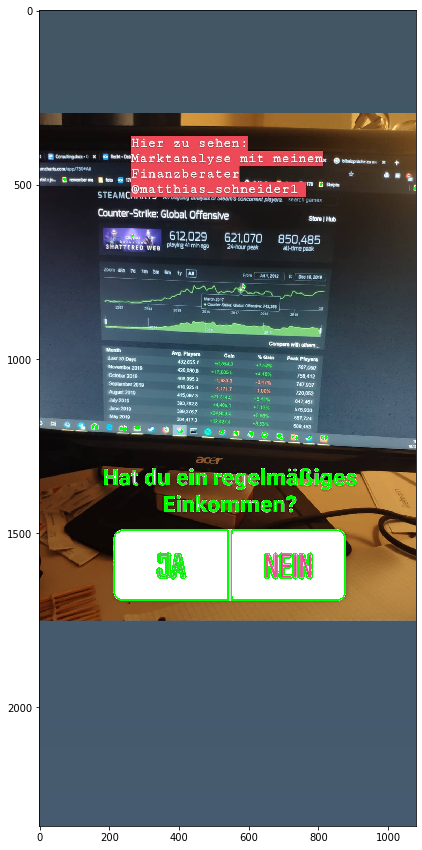

In [6]:
contours_matched_shapes = list(filter(lambda x: 0.01 > cv2.matchShapes(x, contours_filtered[0], 1, 0.0), contours))

display_image_plot(cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3))

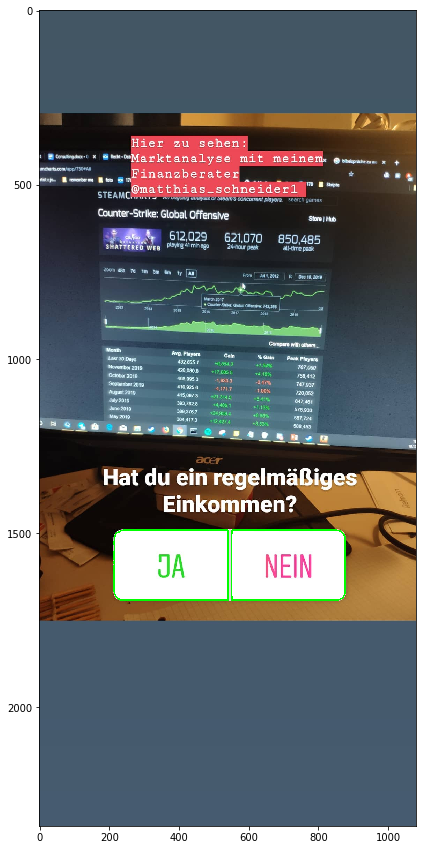

In [7]:
# With shape matching...

display_image_plot(cv2.drawContours(img.copy(), contours_matched_shapes, -1, (0, 255, 0), 3))

Now try to detect text using tesseract.

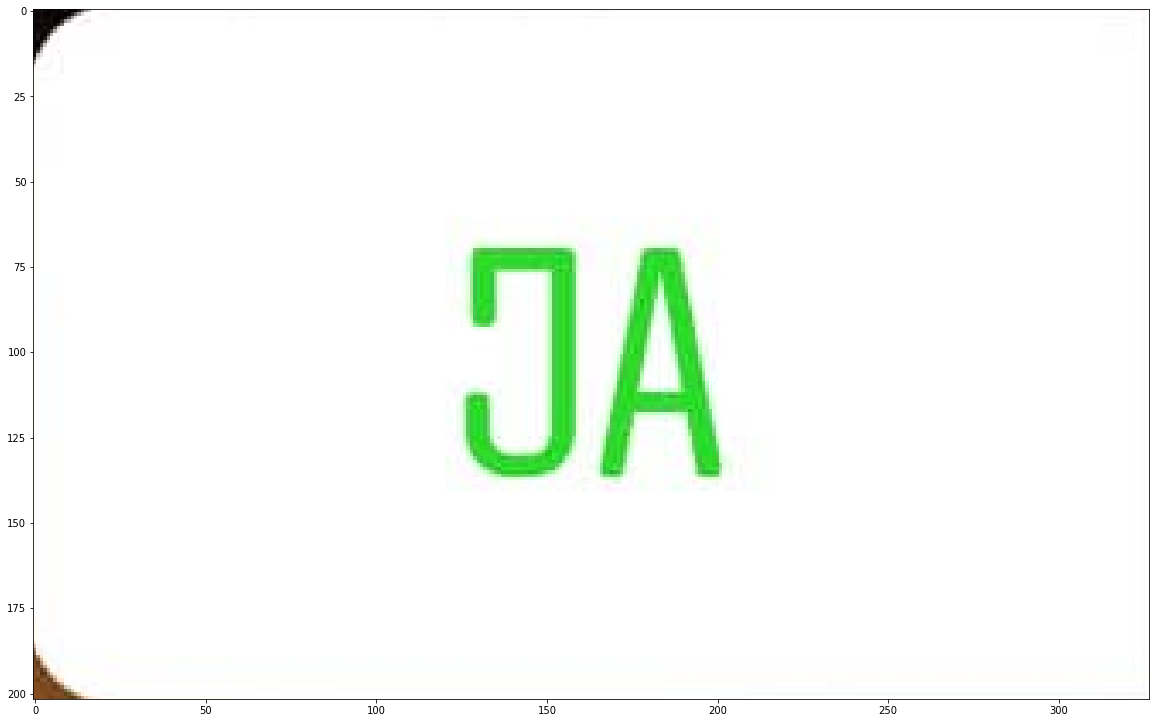

In [8]:
# find text of yes/no

y_contour = cv2.boundingRect(contours_matched_shapes[0])
n_contour = cv2.boundingRect(contours_matched_shapes[1])

(yx, yy, yw, yh) = y_contour
(nx, ny, nw, nh) = n_contour

# flip yes and no, yes is always on the left, x must be smaller.

if yx > nx:
    t = y_contour
    y_contour = n_contour
    n_contour = t
    
(yx, yy, yw, yh) = y_contour
(nx, ny, nw, nh) = n_contour

img_yes = img[yy:yy+yh,yx:yx+yw]
img_no = img[ny:ny+nh,nx:nx+nw]

display_image_plot(img_yes)

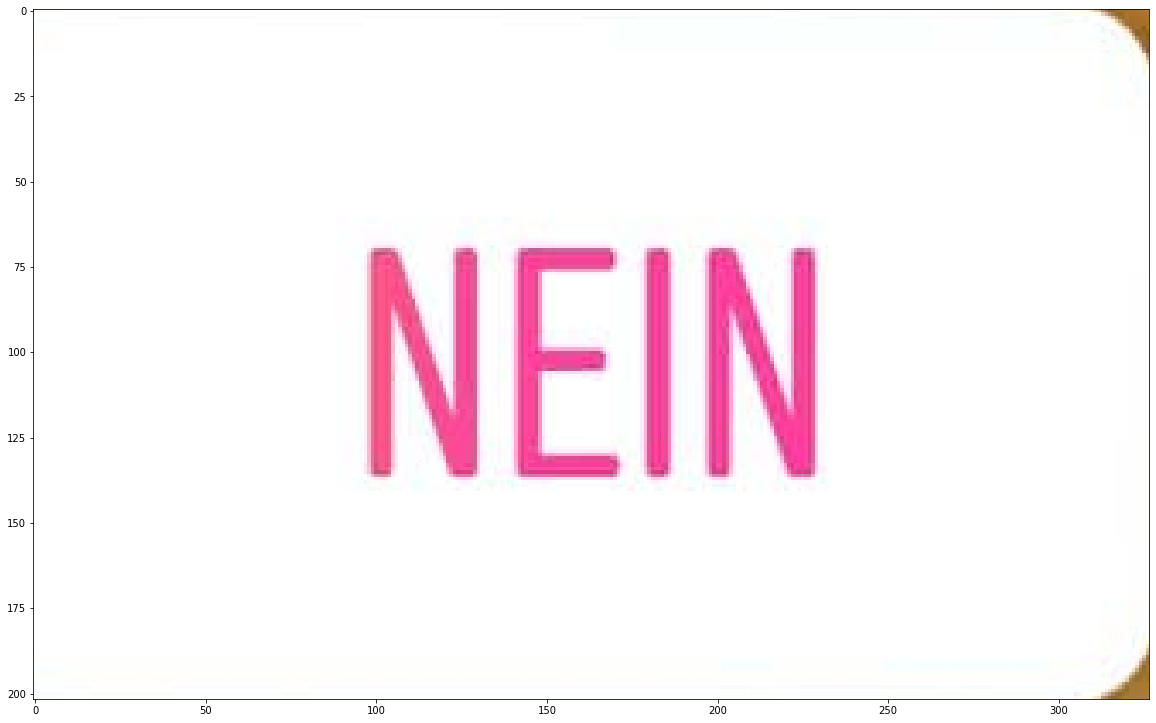

In [9]:
display_image_plot(img_no)

In [10]:
img_no = cv2.cvtColor(img_no, cv2.COLOR_BGR2RGB)
img_yes = cv2.cvtColor(img_yes, cv2.COLOR_BGR2RGB)

pytesseract.image_to_string(img_yes, lang="Aveny", config="--dpi 100"), pytesseract.image_to_string(img_no, lang="Aveny")

# TODO when there are multiple words per yes/no, propably doesnt work, use the approach below

('JA', 'NEIN')

## Now find the text above the fields.
Thoughts:

* The text is always centered above the Yes/no field
* The text has color #FFFFFF

=> Use the mask from above, but remove the already found 

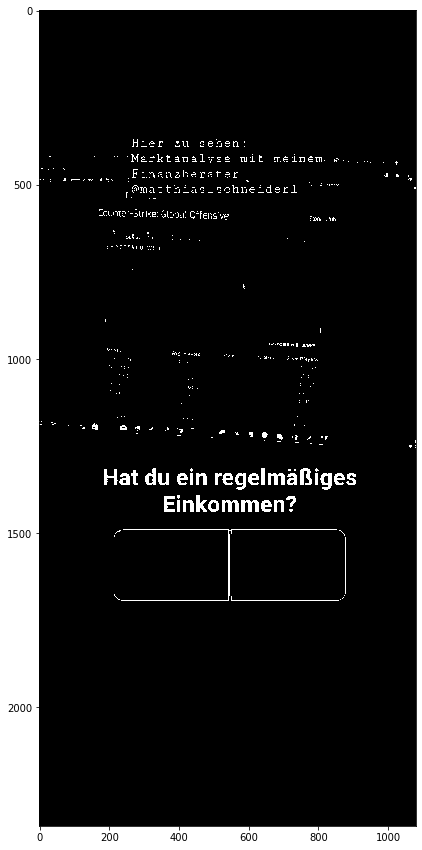

In [11]:
# fill already found yes and no fields
temp_img = cv2.drawContours(img.copy(), contours_matched_shapes, -1, (0,0,0), cv2.FILLED)

th_mask = cv2.inRange(temp_img.copy(), np.array([220,220,220]), np.array([255,255,255]))

display_image_plot(th_mask)

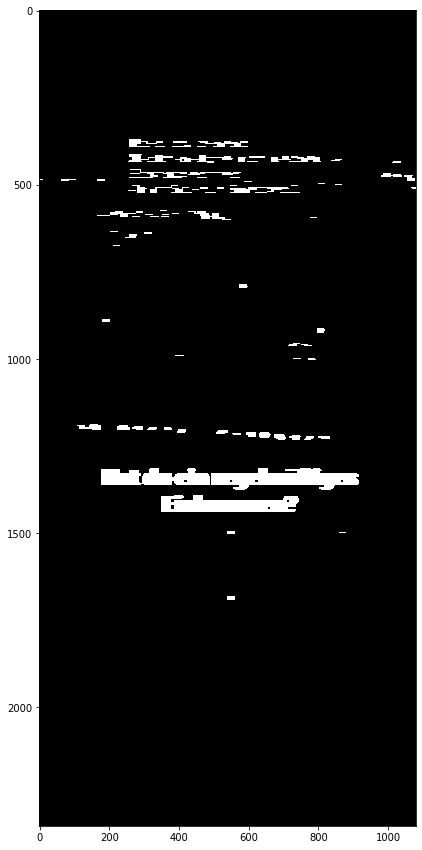

In [12]:
opened = cv2.morphologyEx(th_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))

dilate = cv2.dilate(opened, cv2.getStructuringElement(cv2.MORPH_RECT, (7,1)), iterations = 3)

closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)))

display_image_plot(closing)

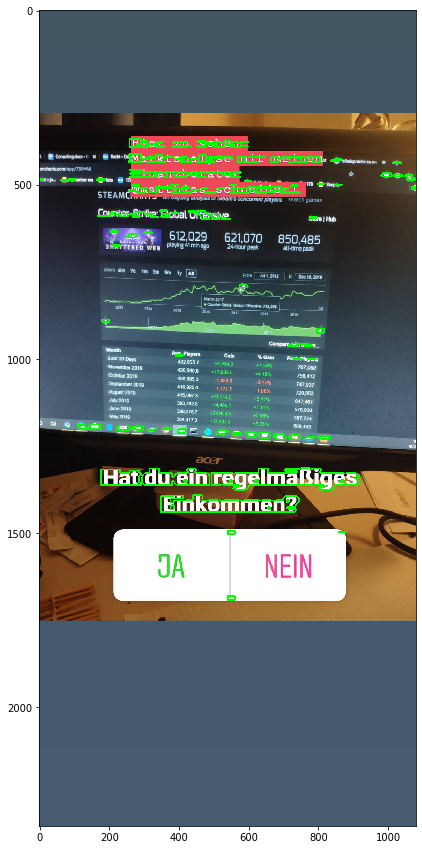

In [13]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

display_image_plot(cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3))

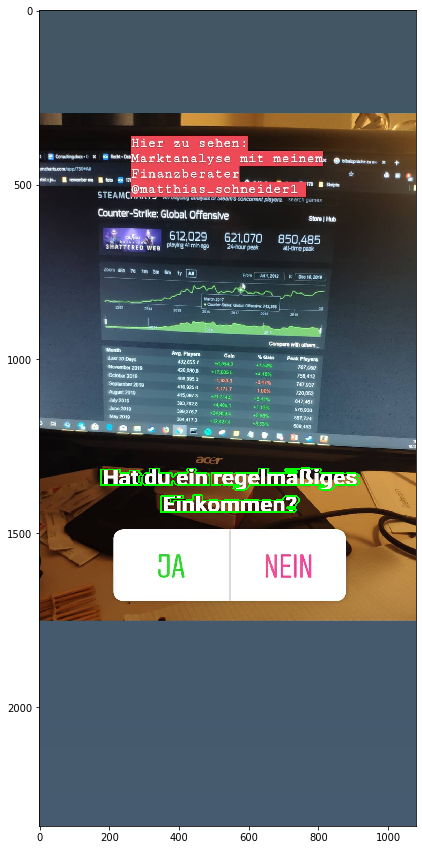

In [14]:
def filter_func(_x):
    _x, _y, _w, _h = cv2.boundingRect(_x)
    _ar = _w / float(_h)
    return _ar > 4 and _h > 20 and _w * _h > img_area * 0.005

contours_filtered = list(filter(lambda _x: filter_func(_x), contours))

display_image_plot(cv2.drawContours(img.copy(), contours_filtered, -1, (0, 255, 0), 3))

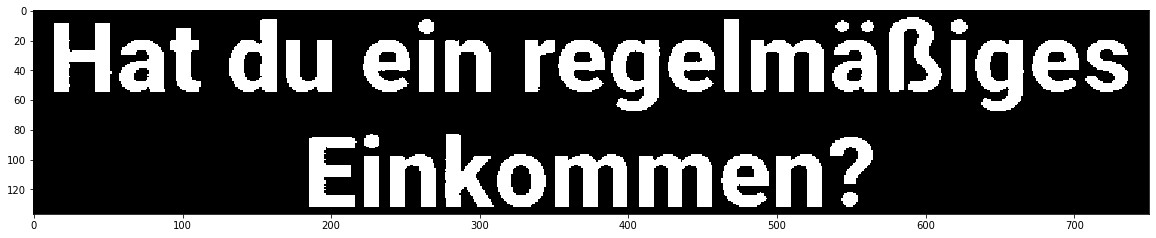

In [15]:
# create a big bounding box for the whole contour aka text
xs = []
ys = []

for contour in contours_filtered:
    x, y, w, h = cv2.boundingRect(contour)
    xs.append(x)
    xs.append(x + w)
    ys.append(y)
    ys.append(y + h)

crop_img = th_mask[min(ys)-5:max(ys)+5, min(xs)-5:max(xs)+5]

display_image_plot(crop_img)

## Better approach: Use tesseract to find bounding boxes, then find the box which is centered above yes no field

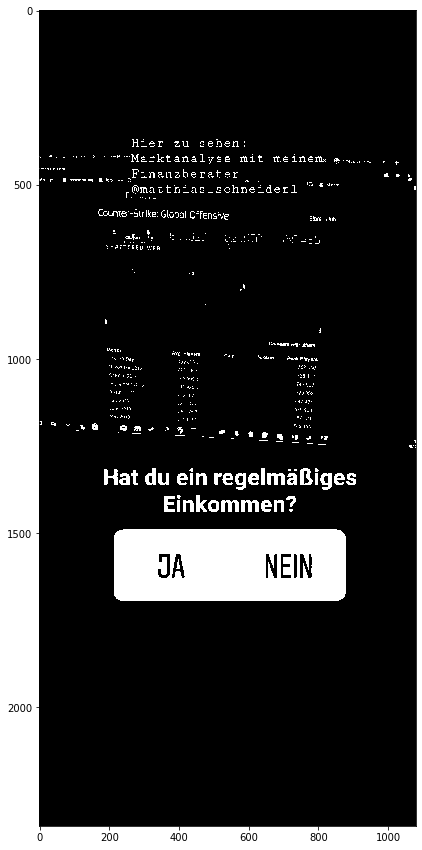

In [16]:
# get text in image, find the text which is centered above the yes/no box.

th_mask = cv2.inRange(img.copy(), np.array([200,200,200]), np.array([255,255,255]))

d = pytesseract.image_to_data(th_mask, output_type=pytesseract.Output.DICT, lang="Aveny+deu+eng")

rec_img = img.copy()

for i in range(len(d['left'])):
    (x, y, w, h, text, conf) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i], d['text'][i], d['conf'][i])
    cv2.rectangle(rec_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
display_image_plot(th_mask)

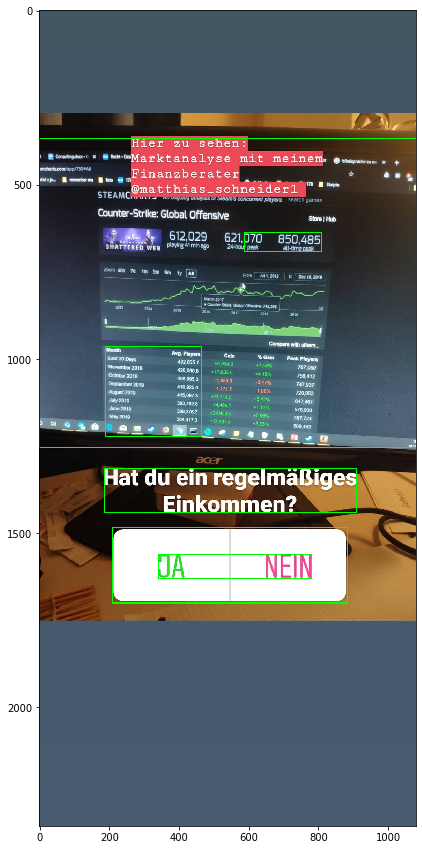

In [17]:
# first condense blocks, else every single word is in one block
condensed_blocks = np.empty(max(d['block_num']) + 1, dtype=tuple)

for i in range(len(d['level'])):
    (x, y, w, h, text, conf, block) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i], d['text'][i], d['conf'][i], d['block_num'][i])
    
    if condensed_blocks[block]:
        (xc, yc, wc, hc, textc, confc, blockc) = condensed_blocks[block]
        minX = min(x, xc)
        minY = min(y, yc)
        
        width = max(x + w, xc + wc) - minX
        height = max(y + h, yc + hc) - minY
        
        newText = textc
        
        if text != '' and text != ' ':
            newText += (' ' + text)
        
        condensed_blocks[block] = (
            minX,
            minY,
            width,
            height,
            newText,
            statistics.mean([float(conf), float(confc)]),
            block
        )
    else:
        condensed_blocks[block] = (x, y, w, h, text, conf, block)
    
# remove block 0, because block 0 contains whole image
condensed_blocks = condensed_blocks[1:]

rec_img = img.copy()

for block in condensed_blocks:
        (x, y, w, h, _, _, _) = block
        cv2.rectangle(rec_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

display_image_plot(rec_img)

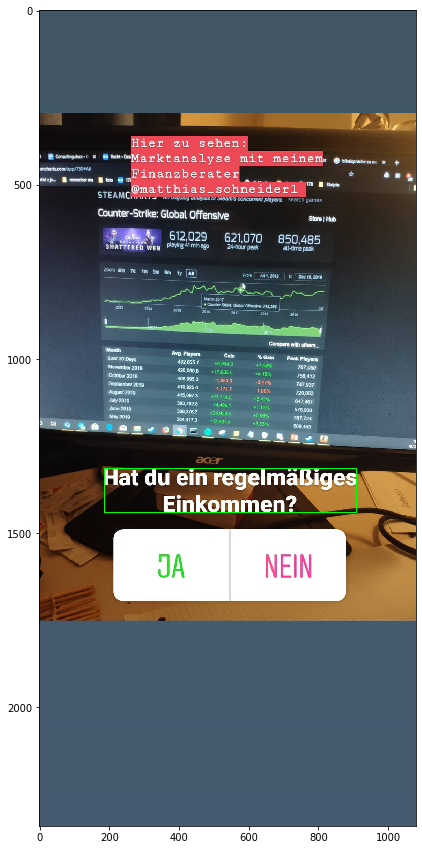

In [18]:
(x_box, y_box, w_box, h_box) = n_contour
center_block = tuple()
dist = float("inf")

def box_to_center(_x, _y, _w, _h):
    return _x + _w / 2, _y + _h / 2

for block in condensed_blocks:
    (cx, cy) = box_to_center(block[0], block[1], block[2], block[3])
    new_dist = math.fabs(cx - x_box)
    
    # exclude blocks which are inside the yes/no box
    if new_dist < dist and not x_box < cx < x_box + w_box and not y_box < cy < y_box + h_box:
        center_block = block

rec_img = img.copy()
        
(x, y, w, h, _, _, _) = center_block
cv2.rectangle(rec_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

display_image_plot(rec_img)

In [20]:
# finally we should have everything scraped:

center_block[4][1:]

'Hat du ein regelmäßiges Einkommen?'